In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import seaborn as sns
import copy

In [2]:
df = pd.read_excel ("market_data.xlsx")

## preprocessing to get date into the correct data type
df['Time (UTC+10)'] = pd.to_datetime(df['Time (UTC+10)'])
df = df[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)"]]

In [3]:
## spliting dataset into 3 categories 
df_train = df.loc[(df["Time (UTC+10)"] < "2021-01-01 00:00:00" )]
df_cross = df.loc[(df["Time (UTC+10)"] >= "2021-01-01 00:00:00" )& (df["Time (UTC+10)"] < "2021-07-01 00:00:00" )]
df_test = df.loc[(df["Time (UTC+10)"] >= "2021-07-01 00:00:00" )]

In [4]:
## convert into numpy array for the algorithm input
df_train = df_train["Regions VIC Trading Price ($/MWh)"].to_numpy()
df_cross = df_cross["Regions VIC Trading Price ($/MWh)"].to_numpy()
df_test = df_test["Regions VIC Trading Price ($/MWh)"].to_numpy()
df_total = df["Regions VIC Trading Price ($/MWh)"].to_numpy()

In [5]:
## helper functions 
## df is the price list, index is the index of df, n is the length of the subsection of the df
## this solution works better if there are  multiple local min or max within the time frame
def compute_optimal_buyout(df, index, n):
    ## buyout refers to the dict which will be modified in the process as an output
    df_segment = df[index: index+n]
    buyout = {}
    ## contrust dictionary
    for i in range(0,len(df_segment)):
        buyout[i] = [df_segment[i],0] 

    ## sort dictionary
    temp = copy.deepcopy(buyout)
    sorted_buyout = {}
    sorted_keys = sorted(buyout, key=buyout.get)
    for i in sorted_keys:
        sorted_buyout[i] = temp[i]
    constraint = [644.4] * n
    ## now find profitable trade deals, and lastly apply contraint
    for i in sorted_buyout:
        remaining = 150
        if sorted_buyout[i][0] * 1.33 > max(df_segment):
            break
        ## for each min price, if you see a profitable price, do something
        for j in range(i, n):
            if remaining <= 0:
                break
            if (sorted_buyout[i][0] * 1.33 < sorted_buyout[j][0] and sorted_buyout[i][0] +20 < sorted_buyout[j][0] and sorted_buyout[i][0] >= 0 and sorted_buyout[i][1] <= 0) or \
                (sorted_buyout[i][0] < 0 and sorted_buyout[i][0] / 1.5 < sorted_buyout[j][0] and sorted_buyout[i][1] <= 0):
                index = j
                temp = j
                ## check if near solution has a immediate better solution from the next 2 time, and repeat if there are
                while(index< n-2):
                    
                    if max(sorted_buyout[index+1][0],sorted_buyout[index+2][0]) > sorted_buyout[index][0]:
                        if  max(sorted_buyout[index+1][0],sorted_buyout[index+2][0]) == sorted_buyout[index+1][0]:
                            temp = index + 1
                        elif  max(sorted_buyout[index+1][0],sorted_buyout[index+2][0]) == sorted_buyout[index+2][0]:
                            temp = index + 2
                        index = index + 2
                    else:
                        break
                ## index is time where we sell at the optimal price and now commence buyout and record it in buyout dict
                index = temp

                
                remaining_dispatch = 135 - sorted_buyout[index][1]
                
                ## remain is the max amount you can buy from the buy point
                ## remain dispatch is the max amount you can sell from the sell point
                ## hardcap is the max amount you can buy due to the limit of capacity
                ## the final amount of electricity you buy will be the most contrained value(minimum) out of all 3

                hardcap = min(150, remaining_dispatch/0.81,remaining)
                ## contraint list tracks all of the capacity during the timeframe
                ## if your deals makes any element fall below 0(the capacity will overcap), the deal need to be restricted. 
                for k in range(i,index + 1):
                    if constraint[k] <= 0:
                        hardcap = 0
                    elif (constraint[k] - min(150, remaining_dispatch/0.81,remaining) < 0) and constraint[k] >0:
                        hardcap = min(hardcap, constraint[k])
                
                for k in range(i,index ):
                    constraint[k] = constraint[k] - hardcap
                        
                remaining_dispatch = min(hardcap * 0.81,remaining * 0.81)
                    
                ## using the amount that you can buy, fill in the rest of the buyout using assumption from the spec
                if remaining_dispatch >= 150 * 0.81:
                    buyout[index][1] += 150 * 0.81

                else:
                    buyout[index][1] = min(135,buyout[index][1] + remaining_dispatch)
                
                buyout[i][1] = sorted_buyout[i][1] - (buyout[index][1] - sorted_buyout[index][1]) / 0.81

                

                remaining =  remaining - (-buyout[i][1] + sorted_buyout[i][1])


                sorted_buyout[i][1] = buyout[i][1]
                sorted_buyout[index][1] = buyout[index][1]
                
    
            

    last_buyout_index = 0
    for i in buyout:
        if buyout[i][1] > 0:
            last_buyout_index = i
            
    return [last_buyout_index,buyout]

In [6]:
## this version works better where there are centered local min and max in the time frame 
def compute_optimal_buyout_v2(df, index, n):
    ## buyout refers to the dict which will be modified in the process as an output
    df_segment = df[index: index+n]
    buyout = {}
    ## contrust dictionary
    for i in range(0,len(df_segment)):
        buyout[i] = [df_segment[i],0] 

    ## sort dictionary
    temp = copy.deepcopy(buyout)
    sorted_buyout = {}
    sorted_buyout_max = {}
    sorted_keys = sorted(buyout, key=buyout.get)
    sorted_keys_rev = sorted(buyout, key=buyout.get,reverse = True)
    for i in sorted_keys:
        sorted_buyout[i] = temp[i]
    for i in sorted_keys_rev:
        sorted_buyout_max[i] = temp[i]
    constraint = [644.4] * n
    ## now find profitable trade deals, and lastly apply contraint
    for i in sorted_buyout:
        remaining = 150
        if sorted_buyout[i][0] * 1.33 > max(df_segment):
            break
        for j in sorted_buyout_max:
            if remaining <= 0:
                break
            if ((sorted_buyout[i][0] * 1.33 < sorted_buyout[j][0] and sorted_buyout[i][0] >= 0 and sorted_buyout[i][1] <= 0) or \
                (sorted_buyout[i][0] < 0 and sorted_buyout[i][0] / 1.5 < sorted_buyout[j][0] and sorted_buyout[i][1] <= 0)) and j > i:
                index = j
                
                remaining_dispatch = 135 - sorted_buyout[index][1]
                
                ## apply contraint 
                hardcap = min(150, remaining_dispatch/0.81,remaining)
                
                for k in range(i,index + 1):
                    if constraint[k] <= 0:
                        hardcap = 0
                    elif (constraint[k] - min(150, remaining_dispatch/0.81,remaining) < 0) and constraint[k] >0:
                        hardcap = min(hardcap, constraint[k])
                
                for k in range(i,index ):
                    constraint[k] = constraint[k] - hardcap
                        
                remaining_dispatch = min(hardcap * 0.81,remaining * 0.81)
                    
                    
                if remaining_dispatch >= 150 * 0.81:
                    buyout[index][1] += 150 * 0.81

                else:
                    buyout[index][1] = min(135,buyout[index][1] + remaining_dispatch)
                
                ##buyout[i][1] = sorted_buyout[i][1] + (buyout[index][1] - sorted_buyout[index][1]) / 0.81
                buyout[i][1] = sorted_buyout[i][1] - (buyout[index][1] - sorted_buyout[index][1]) / 0.81

                
                ##remaining =  remaining - (buyout[i][1] - sorted_buyout[i][1])
                remaining =  remaining - (-buyout[i][1] + sorted_buyout[i][1])

                sorted_buyout[i][1] = buyout[i][1]
                sorted_buyout[index][1] = buyout[index][1]

    last_buyout_index = 0
    for i in buyout:
        if buyout[i][1] > 0:
            last_buyout_index = i
    return [last_buyout_index,buyout]

In [7]:
## using combination of all algorithm to find the best choice in the context
## add other model you think will benefit the algorithm in this part!
def emsemble_optimal_buyout(df, index, n):
    model1 = compute_optimal_buyout(df, index, n)
    model2 = compute_optimal_buyout_v2(df, index, n)

    dict1 = model1[1]
    dict2 = model2[1]
    if compute_profit(dict1) > compute_profit(dict2):
        return model1
    else:
        return model2

In [8]:
## the main function that compute the total profit, capacity and power usage
def main_function(df):
    total_profit = 0
    n = 0
    capacity = 0
    capacityy = []
    power = []
    while (n < len(df)):
        parameter = 48 - n % 24
        output = emsemble_optimal_buyout(df, n, min(parameter, len(df)-n))
        ## recompute parameter if the there are price brought at the last lookout
        
        if output[0] == parameter - 1:
            index = n+parameter-1
            if index + 1 < len(df):
                while df[index+1] > df[index] and index+1 < len(df):
                    index += 1
                output = emsemble_optimal_buyout(df, n, index - n + 1)
        n += output[0] +1
        total_profit += compute_profit(output[1])

        ## compute capacity and power during the timeframe 
        for i in output[1]:
            if output[1][i][1] < 0 and i < output[0] + 1:
                capacity += -output[1][i][1] * 0.9
                power.append(output[1][i][1] * 2)
                capacityy.append(capacity)
            elif output[1][i][1] >= 0 and i <output[0] + 1:
                capacity = capacity - output[1][i][1] / 0.9
                power.append(output[1][i][1] / 0.9 * 2)
                capacityy.append(capacity)

              
              


    return [capacityy, power,total_profit]

In [9]:
## buyout will be a dict that has value [price, amount]
def compute_profit(buyout):
    profit = 0
    for buy in buyout:
        if buyout[buy][1] < 0:
            profit += buyout[buy][0] * buyout[buy][1] /0.991
        else:
            profit += buyout[buy][0] * buyout[buy][1] * 0.991
    return profit

In [10]:
c = main_function(df_total)
total_df_revenue=c[2]

In [11]:
total_df_revenue

126047962.70496097

In [12]:
submission = pd.DataFrame(df["Time (UTC+10)"])
submission["power"] = c[1]
submission["capacity"] = c[0]

In [13]:
## creating the submission csv file
submission.to_csv("sample_submission.csv")

In [14]:
# return the max profit of a period
def emsemble_optimal_profit(df, index, n):
    model1 = compute_optimal_buyout(df, index, n)
    model2 = compute_optimal_buyout_v2(df, index, n)
    dict1 = model1[1]
    dict2 = model2[1]
    if compute_profit(dict1) > compute_profit(dict2):
        return compute_profit(dict1)
    else:
        return compute_profit(dict2)

In [15]:
#sampled period data
visualization_data_set=df.loc[(df["Time (UTC+10)"] >= "2018-01-01 00:30:00" )& (df["Time (UTC+10)"] <= "2021-07-01 00:00:00" )]

#sampled period price
visualization_price=visualization_data_set["Regions VIC Trading Price ($/MWh)"].to_numpy()

#sampled period date
visualization_date=visualization_data_set.drop('Regions VIC Trading Price ($/MWh)', 1)


In [16]:
# the total revenue for the test period
test_period_revenue=main_function(df_test)[2]
test_period_revenue

5890036.217189903

In [17]:
# the total revenue for the sampled period
sample_period_revenue = total_df_revenue - test_period_revenue
sample_period_revenue

120157926.48777106

<Figure size 432x288 with 0 Axes>

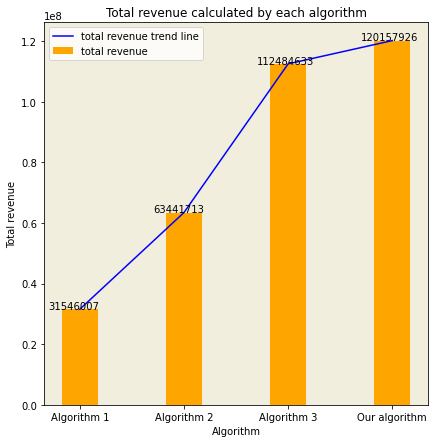

In [18]:
#compare different algorithm in the sampled period
algorithm_list=["Algorithm 1","Algorithm 2","Algorithm 3","Our algorithm"]
profit_list=[31546007,63441713,112484633,round(sample_period_revenue)]

#Use bar plot to show total revenue calculated by each algorithm
fig = plt.figure()
f, ax = plt.subplots(figsize=(6,6))
ax.bar(algorithm_list,profit_list,color='orange',width = 0.35)
plt.plot(algorithm_list,profit_list, '-', color='blue')
ax.legend(labels=["total revenue trend line","total revenue"],prop={'size': 10})
ax.set(facecolor="#F1EEDE")

#add revenue value above each bar
for i, v in enumerate(profit_list):
   plt.text(i-0.3, v + 0.5, str(v))

plt.tight_layout()
plt.title('Total revenue calculated by each algorithm')
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
plt.xlabel('Algorithm')
plt.ylabel('Total revenue')  

#plt.savefig('../ADS_Project2/total revenue per algorithm.png')
plt.show()

In [19]:
## spliting dataset into 4 categories by years

df_2018= df.loc[(df["Time (UTC+10)"] > "2018-01-01 00:00:00" ) & (df["Time (UTC+10)"] <="2019-01-01 00:00:00" )]
df_2019= df.loc[(df["Time (UTC+10)"] > "2019-01-01 00:00:00" ) & (df["Time (UTC+10)"] <="2020-01-01 00:00:00" )]
df_2020= df.loc[(df["Time (UTC+10)"] > "2020-01-01 00:00:00" ) & (df["Time (UTC+10)"] <="2021-01-01 00:00:00" )]
df_2021= df.loc[(df["Time (UTC+10)"] > "2021-01-01 00:00:00" ) & (df["Time (UTC+10)"] <="2021-07-01 00:00:00" )]

df_2018_price = df_2018["Regions VIC Trading Price ($/MWh)"].to_numpy()
df_2019_price = df_2019["Regions VIC Trading Price ($/MWh)"].to_numpy()
df_2020_price = df_2020["Regions VIC Trading Price ($/MWh)"].to_numpy()
df_2021_price = df_2021["Regions VIC Trading Price ($/MWh)"].to_numpy()

#calculate revenue per year
profit_2018=0
k=0
for j in range(int(len(df_2018_price)/48)):
    profit_2018+=emsemble_optimal_profit(df_2018_price[k:k+48],0,48)
    k=k+48

profit_2019=0
k=0
for j in range(int(len(df_2019_price)/48)):
    profit_2019+=emsemble_optimal_profit(df_2019_price[k:k+48],0,48)
    k=k+48

profit_2020=0
k=0
for j in range(int(len(df_2020_price)/48)):
    profit_2020+=emsemble_optimal_profit(df_2020_price[k:k+48],0,48)
    k=k+48

profit_2021=0
k=0
for j in range(int(len(df_2021_price)/48)):
    profit_2021+=emsemble_optimal_profit(df_2021_price[k:k+48],0,48)
    k=k+48

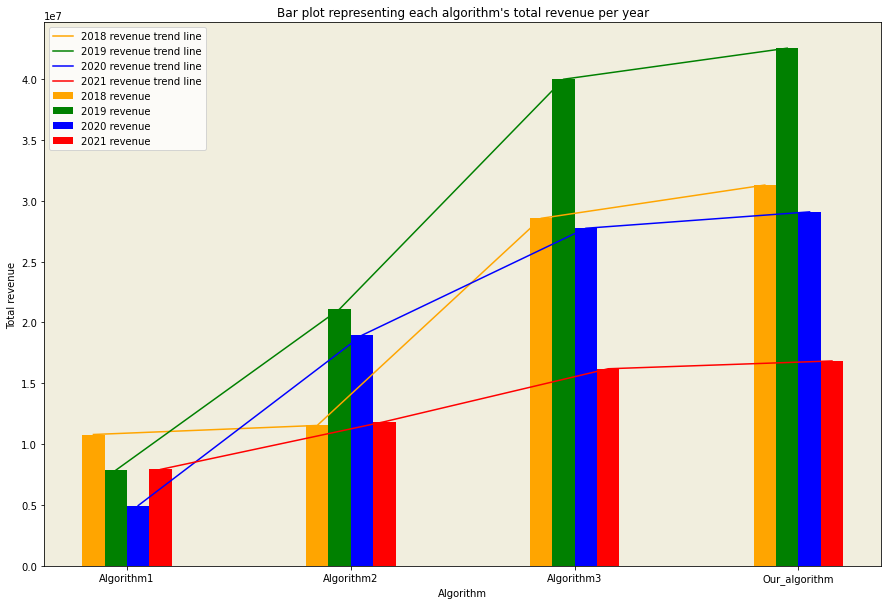

In [20]:
#each year's profit list
profit_2018_list=[10796131,11540098,28558213,round(profit_2018)]
profit_2019_list=[7862888,21103992,39986807,round(profit_2019)]
profit_2020_list=[4958375,18950764,27741739,round(profit_2020)]
profit_2021_list=[7928613,11846859,16197874,round(profit_2021)]

# Declaring the figure or the plot (y, x) or (width, height)
f, ax = plt.subplots(figsize=(15,10))
X = np.arange(len(profit_2018_list))

# Passing the parameters to the bar function, this is the main function which creates the bar plot
# Using X now to align the bars side by side
width=5
plt.bar(X + 0.1, profit_2018_list, color = 'orange', width = 0.1)
plt.bar(X + 0.2, profit_2019_list, color = 'g', width = 0.1)
plt.bar(X + 0.3, profit_2020_list, color = 'b', width = 0.1)
plt.bar(X + 0.4, profit_2021_list, color = 'r', width = 0.1)
plt.plot(X + 0.1,profit_2018_list, '-', color='orange')
plt.plot(X + 0.2,profit_2019_list, '-', color='g')
plt.plot(X + 0.3,profit_2020_list, '-', color='b')
plt.plot(X + 0.4,profit_2021_list, '-', color='r')

# Creating the legend of the bars in the plot
plt.legend(['2018 revenue trend line', '2019 revenue trend line', '2020 revenue trend line','2021 revenue trend line',
            '2018 revenue', '2019 revenue', '2020 revenue','2021 revenue'])

plt.xticks([i + 0.25 for i in range(4)], ['Algorithm1', 'Algorithm2', 'Algorithm3', 'Our_algorithm'])

plt.title("Bar plot representing each algorithm's total revenue per year")
ax.set(facecolor="#F1EEDE")

plt.xlabel('Algorithm')
plt.ylabel('Total revenue')
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)

# Saving the plot as a 'png'
# plt.savefig("each algorithm's total revenue per year.png")

# Displaying the bar plot
plt.show()